In [1]:
import scipy
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
import numpy as np
from corner import quantile
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})
from PIL import Image
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from mpl_toolkits.basemap import Basemap
from pyproj import Proj
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## An exercise in quantile mapping:

“Quantile mapping bias correction algorithms are commonly used to correct systematic distributional biases in precipitation outputs from climate models” (Cannon+2015)

Essentially, climate models are compared to historical observations over some medium- to long-term timescales (decades) so that the model projections can be corrected for any systematic bias. There are several ways to do bias corrections but a class of techniques generally called quantile mapping aim to preserve the characteristics of the observed trends (for, e.g., temps, this can mean the mean as well as the extreme values at the tails of the distribution) as well as include the long term trends in the climate models (these techniques are typically called quantile delta mapping).

Below I'll attempt to explore how these algorithms work.


## Quantile Delta Mapping

“[...] Quantile delta mapping (QDM), explicitly preserves relative changes in simulated precipitation quantiles from a climate model. Systematic distributional biases relative to observations in a historical baseline period are corrected by first detrending all projected future quantiles from a model and then applying quantile mapping to the detrended series. After detrending and quantile mapping, projected trends in the modeled quantiles are reintroduced on top of the bias-corrected outputs, thus ensuring that the climate sensitivity of the underlying climate model, at least so far as quantiles are concerned, is unaffected by the bias correction.” (Cannon+2015)

![qdm](https://journals.ametsoc.org/view/journals/clim/28/17/full-jcli-d-14-00754.1-f1.jpg)

First, for the projected model data, the outputs are detrended by their quantile (basically removing the effect of the climate model). This is done by finding the quantile of the projected output at some time and the same quantile in the historic model data (Eq. 3 in Cannon+2015) and then finding the relative change in the value (== delta quantile, Eq 4). Then the projected model quantile can be bias corrected from the observed values over the historical period (Eq. 5) which can then be applied to bias correct the projected value (Eq. 6).

## Exercise with Synthetic Data: Quantile Mapping

Following Cannon+15 (which itself follows Maurer & Pierce 2014), we assume the synthetic observations of precipitation and the climate model outputs both follow a gamma distribution,, 

In [40]:
mu = 30
std = 15
scale=7.5
synthetic_obs_dist = scipy.stats.gamma(a=mu/scale, scale=scale)
mu = 30
std = 10.5
scale=3.68
historical_model_dist = scipy.stats.gamma(a=mu/scale, scale=scale)
mu = 42
std = 10.5
scale=2.63
projected_model_dist = scipy.stats.gamma(a=mu/scale, scale=scale)
draws = np.linspace(0,100,10000)

obs_rvs = synthetic_obs_dist.rvs(len(draws))
hm_rvs = historical_model_dist.rvs(len(draws))
pm_rvs = projected_model_dist.rvs(len(draws))

obs_pdf = synthetic_obs_dist.pdf(draws)
hm_pdf = historical_model_dist.pdf(draws)
pm_pdf = projected_model_dist.pdf(draws)

obs_cdf = synthetic_obs_dist.cdf(draws)
hm_cdf = historical_model_dist.cdf(draws)
pm_cdf = projected_model_dist.cdf(draws)

In [4]:
print(synthetic_obs_dist.mean(),
historical_model_dist.mean(),
projected_model_dist.mean())

30.0 30.000000000000004 42.0


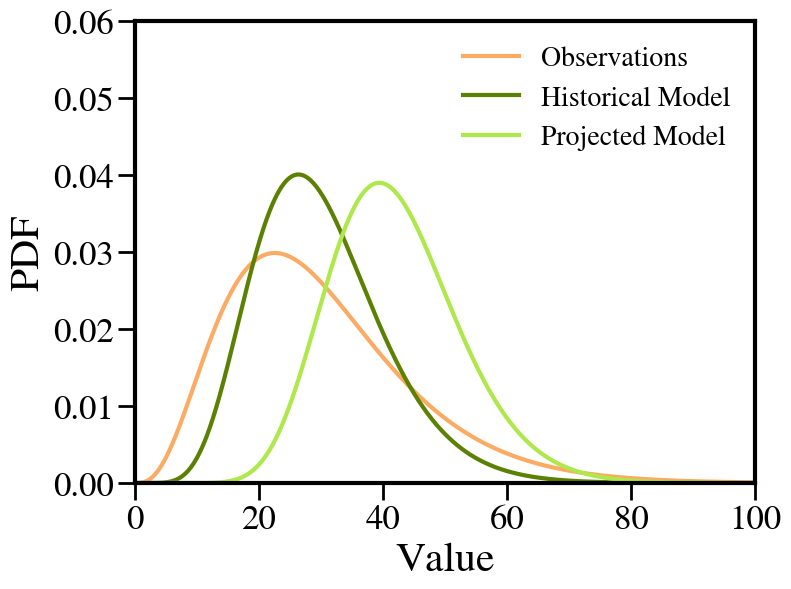

In [4]:
plt.plot(draws,obs_pdf, color='#FCAB64',lw=3, label='Observations')
plt.plot(draws,hm_pdf,color='#5C8001', lw=3, label='Historical Model')
plt.plot(draws,pm_pdf,color='#AEE84A', lw=3, label='Projected Model')
plt.ylabel('PDF')
plt.xlabel('Value')
plt.ylim([0,0.06])
plt.xlim([0,100])
plt.legend(frameon=False)

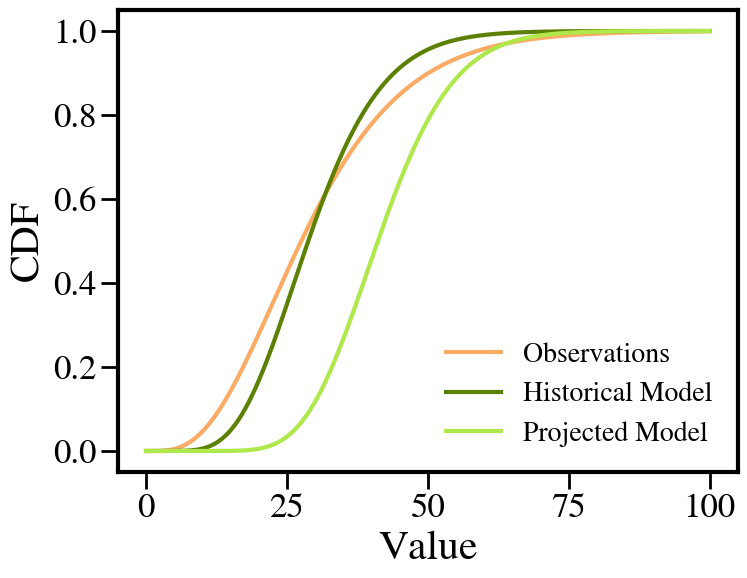

In [5]:
plt.plot(draws,obs_cdf, color='#FCAB64',lw=3, label='Observations')
plt.plot(draws,hm_cdf,color='#5C8001', lw=3, label='Historical Model')
plt.plot(draws,pm_cdf,color='#AEE84A', lw=3, label='Projected Model')
#plt.plot(draws,projected_model_dist.cdf(synthetic_obs_dist.ppf(hm_cdf)))
plt.ylabel('CDF')
plt.xlabel('Value')
plt.legend(frameon=False)

In this example, the observed and modeled data for the historical period have the same mean, but the GCM underestimates the observed standard deviation by 30%; the model projects a 40% increase in the mean for the future period, with no accompanying change in the standard deviation.

In [5]:
#define some time periods and gather data points
historical_time = np.arange(1971,2000,0.1)
projected_time = np.arange(2041, 2070, 0.05)

observations = synthetic_obs_dist.rvs(len(historical_time))
hist_model = historical_model_dist.rvs(len(historical_time))
proj_model = projected_model_dist.rvs(len(projected_time))

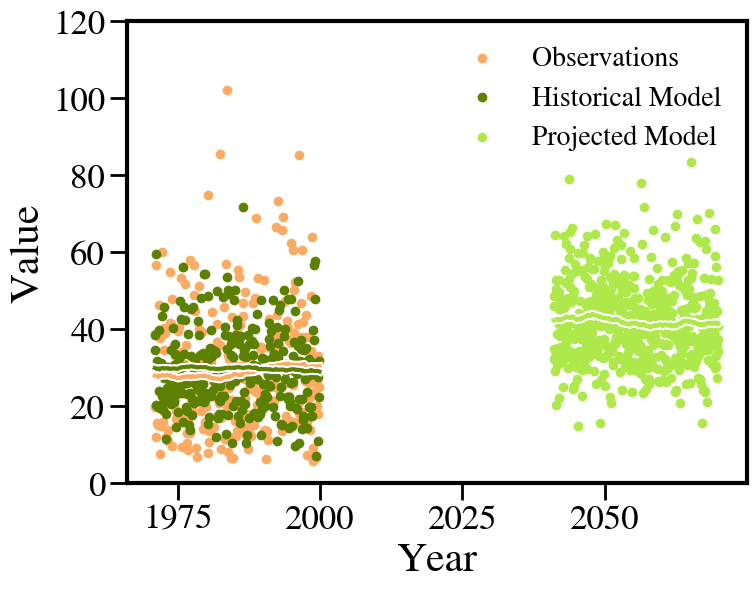

In [45]:
plt.scatter(historical_time, observations, color='#FCAB64',label='Observations')
plt.scatter(historical_time, hist_model,color='#5C8001', label='Historical Model')
plt.scatter(projected_time, proj_model,color='#AEE84A', label='Projected Model')

#np convolve to get running average
w=150
hist_mean=np.convolve(hist_model, np.ones(w), mode='valid')/w
proj_mean=np.convolve(proj_model, np.ones(w), mode='valid')/w
obs_mean=np.convolve(observations, np.ones(w), mode='valid')/w
htime = np.linspace(historical_time[0], historical_time[-1], len(hist_mean))
ptime = np.linspace(projected_time[0], projected_time[-1], len(proj_mean))
plt.plot(htime, obs_mean, color='white', lw=6)
plt.plot(htime, obs_mean, color='#FCAB64', lw=3)

plt.plot(htime, hist_mean, color='white', lw=6)
plt.plot(htime, hist_mean, color='#5C8001', lw=3)

plt.plot(ptime, proj_mean, color='white', lw=6)
plt.plot(ptime, proj_mean, color='#AEE84A', lw=3)


plt.xlabel('Year')
plt.ylabel('Value')
plt.ylim([0,120])
plt.legend(frameon=False)

If CDFs and inverse CDFs (i.e., quantile functions) are estimated empirically from the data, the algorithm can be illustrated with the aid of a quantile–quantile plot, which is the scatterplot between empirical quantiles of observed and modeled data (i.e., the sorted values in each sample when the number of observed and modeled samples are the same). In this case, QM amounts to a lookup table whose entries are found by interpolating between points in the quantile–quantile plot of the historical data. The transfer function is constructed using information from the historical period exclusively;

In [58]:
proj_model_qm = synthetic_obs_dist.ppf(historical_model_dist.cdf(proj_model))

Here I'm following equation 1 of Cannon+2015 by finding the quantiles of the projected model values in the observed CDF.

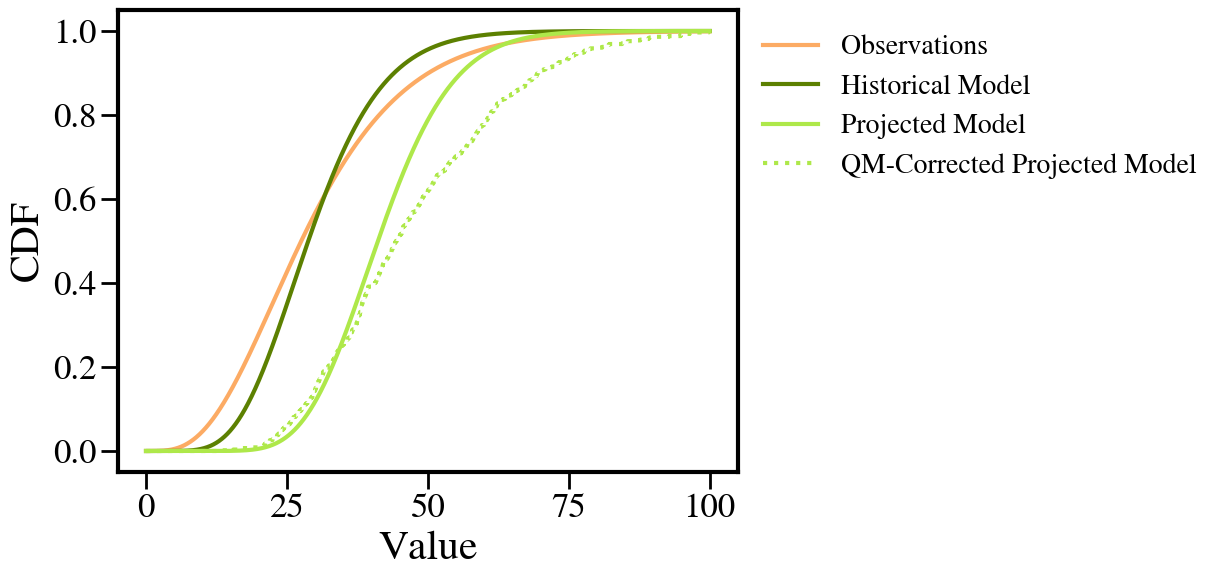

In [66]:
plt.plot(draws,obs_cdf, color='#FCAB64',lw=3, label='Observations')
plt.plot(draws,hm_cdf,color='#5C8001', lw=3, label='Historical Model')
plt.plot(draws,pm_cdf,color='#AEE84A', lw=3, label='Projected Model')
plt.plot(draws, ECDF(proj_model_qm)(draws), lw=3, ls=':',color='#AEE84A', label='QM-Corrected Projected Model')
plt.ylabel('CDF')
plt.xlabel('Value')
plt.legend(frameon=False, bbox_to_anchor=(1,1))

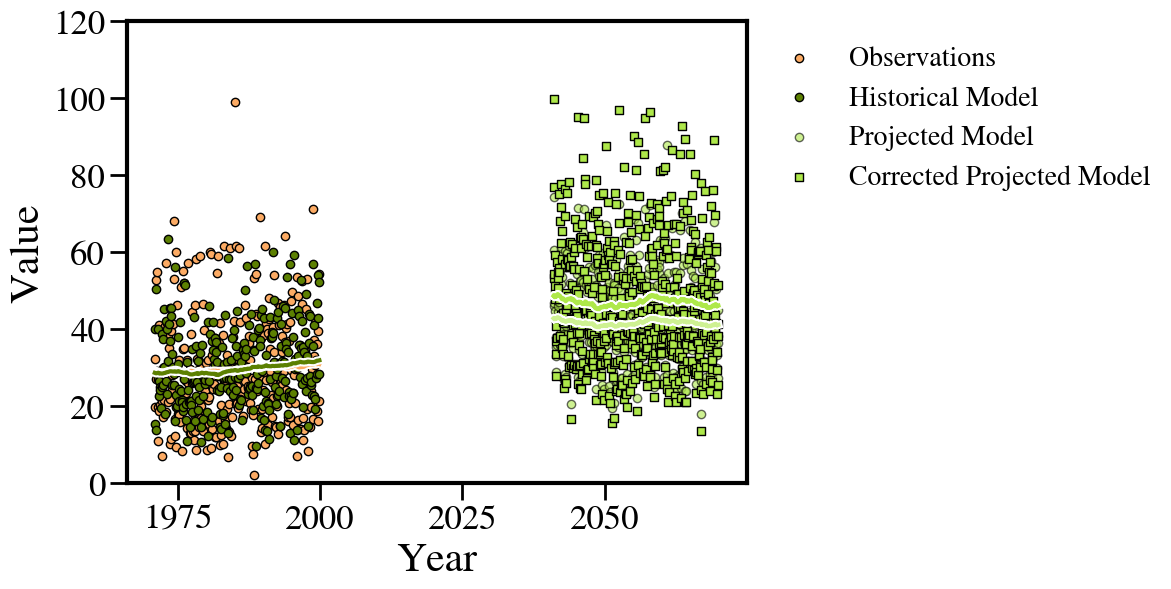

In [60]:
plt.scatter(historical_time, observations, edgecolor='black', color='#FCAB64',label='Observations')
plt.scatter(historical_time, hist_model,edgecolor='black',color='#5C8001', label='Historical Model')
plt.scatter(projected_time, proj_model,edgecolor='black',color='#AEE84A', alpha=0.6, label='Projected Model')
plt.scatter(projected_time, proj_model_qm, edgecolor='black',color='#AEE84A', marker='s', label='Corrected Projected Model')

#np convolve to get running average
w=150
hist_mean=np.convolve(hist_model, np.ones(w), mode='valid')/w
proj_mean=np.convolve(proj_model, np.ones(w), mode='valid')/w
obs_mean=np.convolve(observations, np.ones(w), mode='valid')/w
corr_proj_mean = np.convolve(proj_model_qm, np.ones(w), mode='valid')/w
htime = np.linspace(historical_time[0], historical_time[-1], len(hist_mean))
ptime = np.linspace(projected_time[0], projected_time[-1], len(proj_mean))
plt.plot(htime, obs_mean, color='white', lw=6)
plt.plot(htime, obs_mean, color='#FCAB64', lw=3)

plt.plot(htime, hist_mean, color='white', lw=6)
plt.plot(htime, hist_mean, color='#5C8001', lw=3)

plt.plot(ptime, proj_mean, color='white', lw=6)
plt.plot(ptime, proj_mean, color='#AEE84A',alpha=0.6, lw=3)

plt.plot(ptime, corr_proj_mean, color='white', lw=6)
plt.plot(ptime, corr_proj_mean, color='#AEE84A', lw=3)

plt.xlabel('Year')
plt.ylabel('Value')
plt.ylim([0,120])
plt.legend(frameon=False, bbox_to_anchor=(1,1))

In [63]:
np.mean(proj_model_qm), np.mean(proj_model), np.mean(observations)

(47.169317327177126, 41.78853948418614, 29.630770904650046)

In [64]:
np.std(proj_model_qm), np.std(proj_model)

(16.746394806775857, 10.799445765496204)

However, while the skew of the projected model aligns more with the historical data, the projected increase in the mean is no longer just ~40% but now at ~60%: As demonstrated by Maurer and Pierce (2014), underestimation of variance for a bounded, right-skewed variable will result in an amplification of projected trends in the mean by QM (and vice versa for overestimation of variance)

In [67]:
#now for the PDF from the actual distributions
corr_pm_rvs_qm = synthetic_obs_dist.ppf(historical_model_dist.cdf(sorted(pm_rvs)))
corr_pm_kde = scipy.stats.gaussian_kde(corr_pm_rvs_qm)
corr_pm_pdf = corr_pm_kde(draws)

#corrected_proj_model_qm_pdf =scipy.stats.gaussian_kde(corrected_proj_model_qm_rvs)(draws)

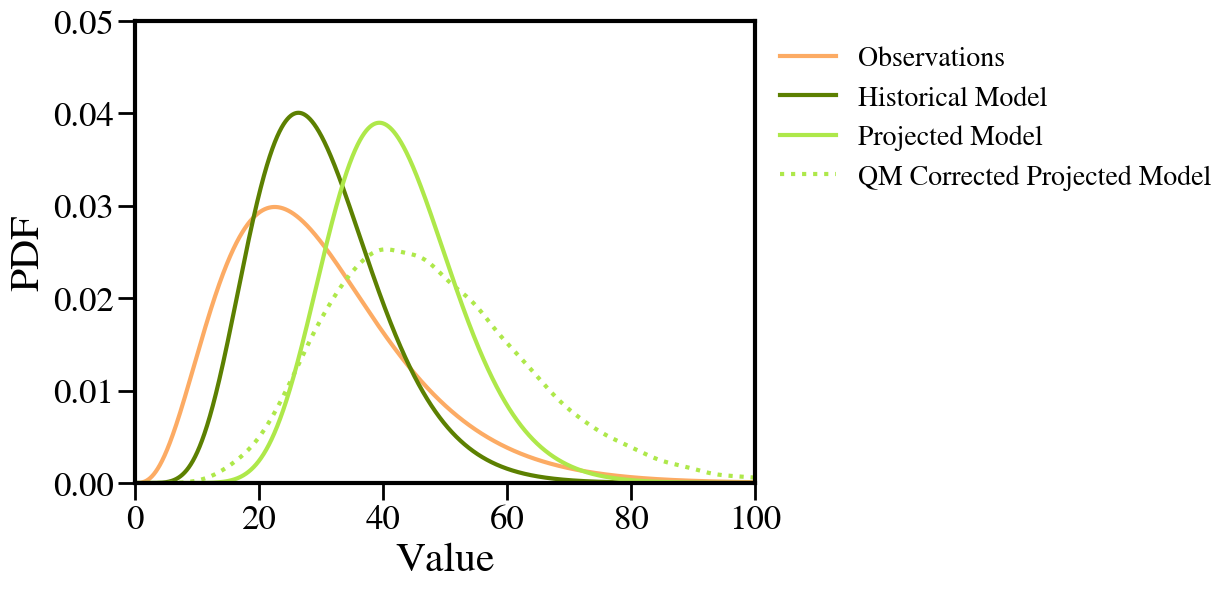

In [68]:
plt.plot(draws,obs_pdf, color='#FCAB64',lw=3, label='Observations')
plt.plot(draws,hm_pdf,color='#5C8001', lw=3, label='Historical Model')
plt.plot(draws,pm_pdf,color='#AEE84A', lw=3, label='Projected Model')
plt.plot(draws, corr_pm_pdf, color='#AEE84A', lw=3, ls=':', label='QM Corrected Projected Model')
plt.ylabel('PDF')
plt.xlabel('Value')
plt.ylim([0,0.05])
plt.xlim([0,100])
plt.legend(frameon=False, bbox_to_anchor=(1,1))

In [69]:
print(projected_model_dist.mean(), np.mean(corr_pm_rvs_qm))

42.0 47.62996925100956


In [70]:
print(projected_model_dist.std(), np.std(corr_pm_rvs_qm))

10.509995242624994 16.352017641559513


Owing to the amplification of projected trends in the mean by QM, we can instead apply the detrended quantile mapping technique, which enables us to avoid extrapolating for values that lie outside of the historical data (like for the projected increase in the mean by 40%).

## Exercise with Synthetic Data: Detrended Quantile Mapping

In [71]:
#detrended quantile mapping

projected_mean = np.mean(proj_model)
historical_mean = np.mean(hist_model)

proj_model_dqm = synthetic_obs_dist.ppf(historical_model_dist.cdf((historical_mean/projected_mean)*proj_model))* (projected_mean/historical_mean)


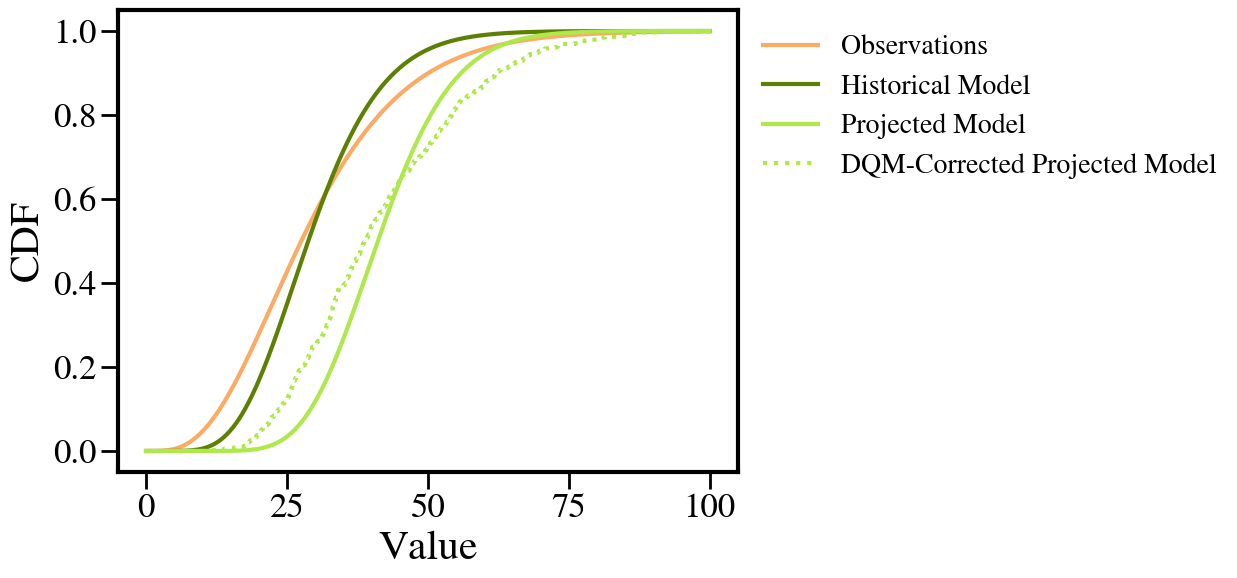

In [72]:
plt.plot(draws,obs_cdf, color='#FCAB64',lw=3, label='Observations')
plt.plot(draws,hm_cdf,color='#5C8001', lw=3, label='Historical Model')
plt.plot(draws,pm_cdf,color='#AEE84A', lw=3, label='Projected Model')
plt.plot(draws, ECDF(proj_model_dqm)(draws), lw=3, ls=':',color='#AEE84A', label='DQM-Corrected Projected Model')
plt.ylabel('CDF')
plt.xlabel('Value')
plt.legend(frameon=False, bbox_to_anchor=(1,1))

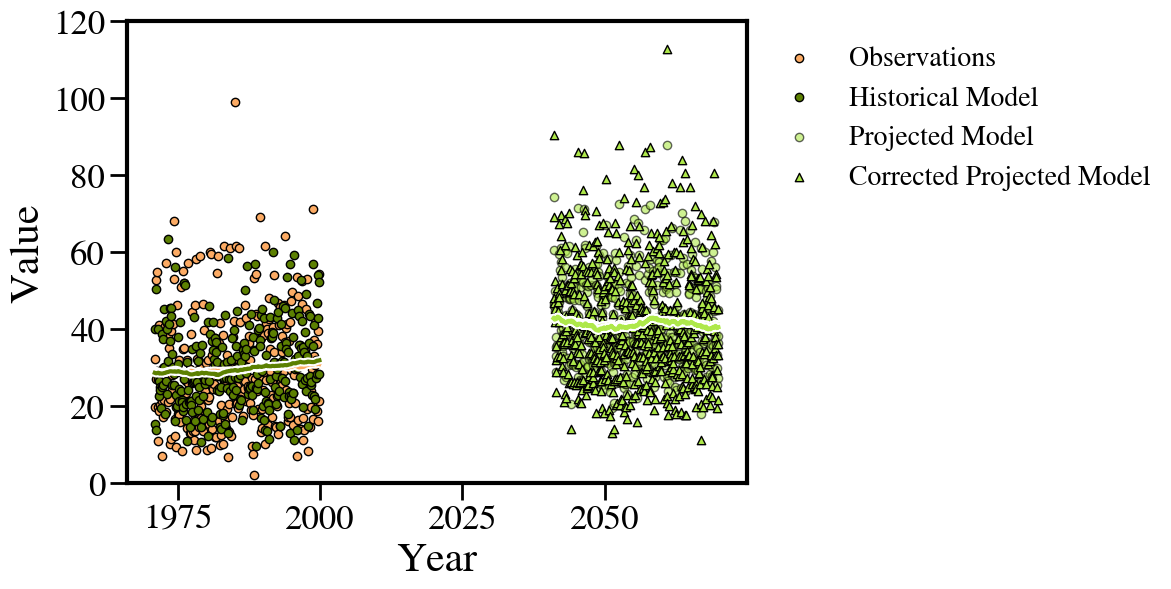

In [73]:
plt.scatter(historical_time, observations, edgecolor='black', color='#FCAB64',label='Observations')
plt.scatter(historical_time, hist_model,edgecolor='black',color='#5C8001', label='Historical Model')
plt.scatter(projected_time, proj_model,edgecolor='black',color='#AEE84A', alpha=0.6, label='Projected Model')
plt.scatter(projected_time, proj_model_dqm, edgecolor='black',color='#AEE84A', marker='^', label='Corrected Projected Model')

#np convolve to get running average
w=150
hist_mean=np.convolve(hist_model, np.ones(w), mode='valid')/w
proj_mean=np.convolve(proj_model, np.ones(w), mode='valid')/w
obs_mean=np.convolve(observations, np.ones(w), mode='valid')/w
corr_proj_mean = np.convolve(proj_model_dqm, np.ones(w), mode='valid')/w
htime = np.linspace(historical_time[0], historical_time[-1], len(hist_mean))
ptime = np.linspace(projected_time[0], projected_time[-1], len(proj_mean))
plt.plot(htime, obs_mean, color='white', lw=6)
plt.plot(htime, obs_mean, color='#FCAB64', lw=3)

plt.plot(htime, hist_mean, color='white', lw=6)
plt.plot(htime, hist_mean, color='#5C8001', lw=3)

plt.plot(ptime, proj_mean, color='white', lw=6)
plt.plot(ptime, proj_mean, color='#AEE84A',alpha=0.6, lw=3)

plt.plot(ptime, corr_proj_mean, color='white', lw=6)
plt.plot(ptime, corr_proj_mean, color='#AEE84A', lw=3)

plt.xlabel('Year')
plt.ylabel('Value')
plt.ylim([0,120])
plt.legend(frameon=False, bbox_to_anchor=(1,1))

In [75]:
np.mean(proj_model_dqm), np.mean(proj_model), np.mean(observations)

(41.45615202892342, 41.78853948418614, 29.630770904650046)

In [76]:
np.std(proj_model_dqm), np.std(proj_model)

(15.41566082196231, 10.799445765496204)

In [77]:
detrended_rvs = np.array(sorted(pm_rvs))*(historical_mean/projected_mean)

corr_pm_rvs_dqm = synthetic_obs_dist.ppf(historical_model_dist.cdf(detrended_rvs))*(projected_mean/historical_mean)
corr_pm_kde_dqm = scipy.stats.gaussian_kde(corr_pm_rvs_dqm)
corr_pm_pdf_dqm = corr_pm_kde_dqm(draws)

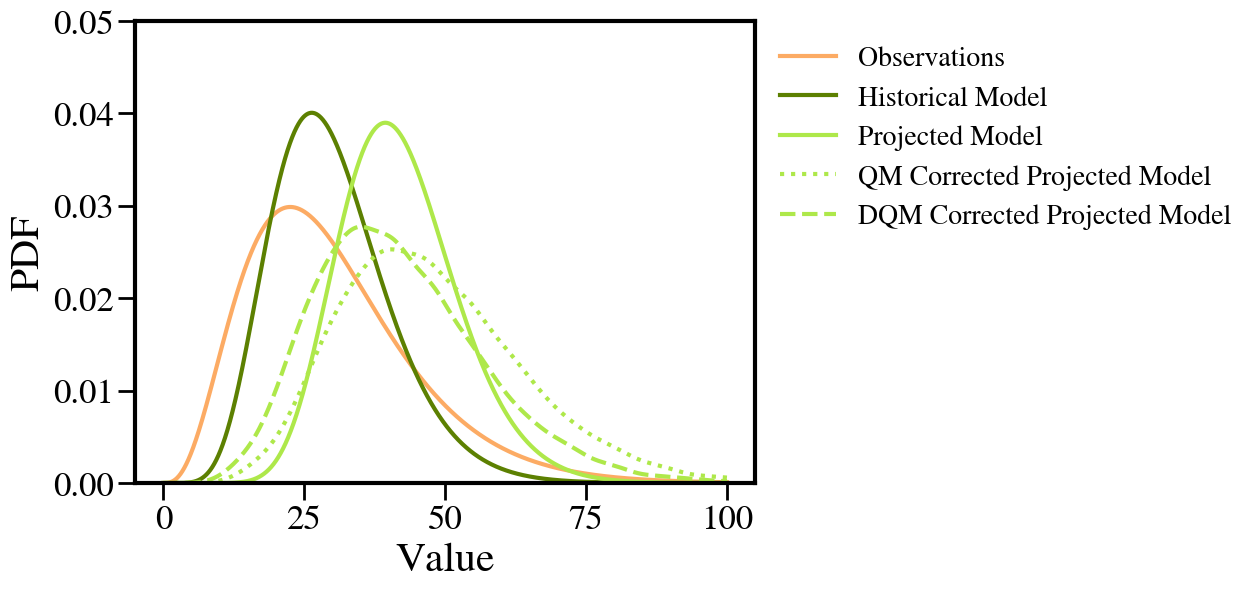

In [78]:
plt.plot(draws,obs_pdf, color='#FCAB64',lw=3, label='Observations')
plt.plot(draws,hm_pdf,color='#5C8001', lw=3, label='Historical Model')
plt.plot(draws,pm_pdf,color='#AEE84A', lw=3, label='Projected Model')
plt.plot(draws, corr_pm_pdf, color='#AEE84A', lw=3, ls=':', label='QM Corrected Projected Model')
plt.plot(draws, corr_pm_pdf_dqm, color='#AEE84A', lw=3, ls='--', label='DQM Corrected Projected Model')
plt.ylabel('PDF')
plt.xlabel('Value')
plt.ylim([0,0.05])
plt.legend(frameon=False, bbox_to_anchor=(1,1))

In [79]:
print(projected_model_dist.mean(), np.mean(corr_pm_rvs_dqm))

42.0 41.87352508932044


In [80]:
print(projected_model_dist.std(),np.std(corr_pm_rvs_dqm), synthetic_obs_dist.std())

10.509995242624994 15.051558963895756 15.0


## Exercise with Real Data: Quantile Mapping Gridded Data

In the blend, quantile mapping is done at every grid point for every model for every forecast lead time. The observations are compiled over a timescale of 60 days to construct the CDFs while the model CDFs are (for the ensemble models) constructed from all members. 

We'll do a watered down version here: we'll load in 50 days of URMA data (our observations) and construct the CDF of temperature for one grid point.  

We'll then load in the ensemble members for GEFS and construct the model CDF from all members. As stated above, the QM is done for every forecast lead time, but here we will just focus on the first lead time; in effect, we will be quantile mapping _just_ the "historical model" to the observational data if we compare to the exercise above (ignoring any "projected model" mapping).

** A Note **
Not only is this a very watered down example but the URMA and GEFS data are from two different periods. I know, I know, this doesn't make any sense but it'll just be for illustrative purposes.

In [146]:
urma_dir='/scratch2/STI/mdl-sti/Eric.Engle/urma_climo/urma/'
first_day=datetime.date(2020,1,29)   
urma_path = urma_dir+f'urma2p5.{first_day.strftime("%Y%m%d")}/urma2p5.t00z.2dvaranl_ndfd.grb2_wexp.grib2io'


filters = dict(productDefinitionTemplateNumber=0, typeOfFirstFixedSurface=103,shortName='TMP')
u1 = xr.open_dataset(urma_path,engine='grib2io', filters=filters)

In [169]:
adam_dat_dir = '/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/gefs/20230129/atmos/'
gefs_paths = sorted(glob(adam_dat_dir+'gep*.t12z.pgrb2ab.0p50'))
filters = dict(productDefinitionTemplateNumber=1, typeOfFirstFixedSurface=1,shortName='TMP',leadTime=u1.leadTime.data)
g1 = xr.open_dataset(gefs_paths[0],engine='grib2io', filters=filters)

Let's first get a feel for the data - first time working with URMA!!

Text(0.5, 1.0, 'GEFS Member 1')

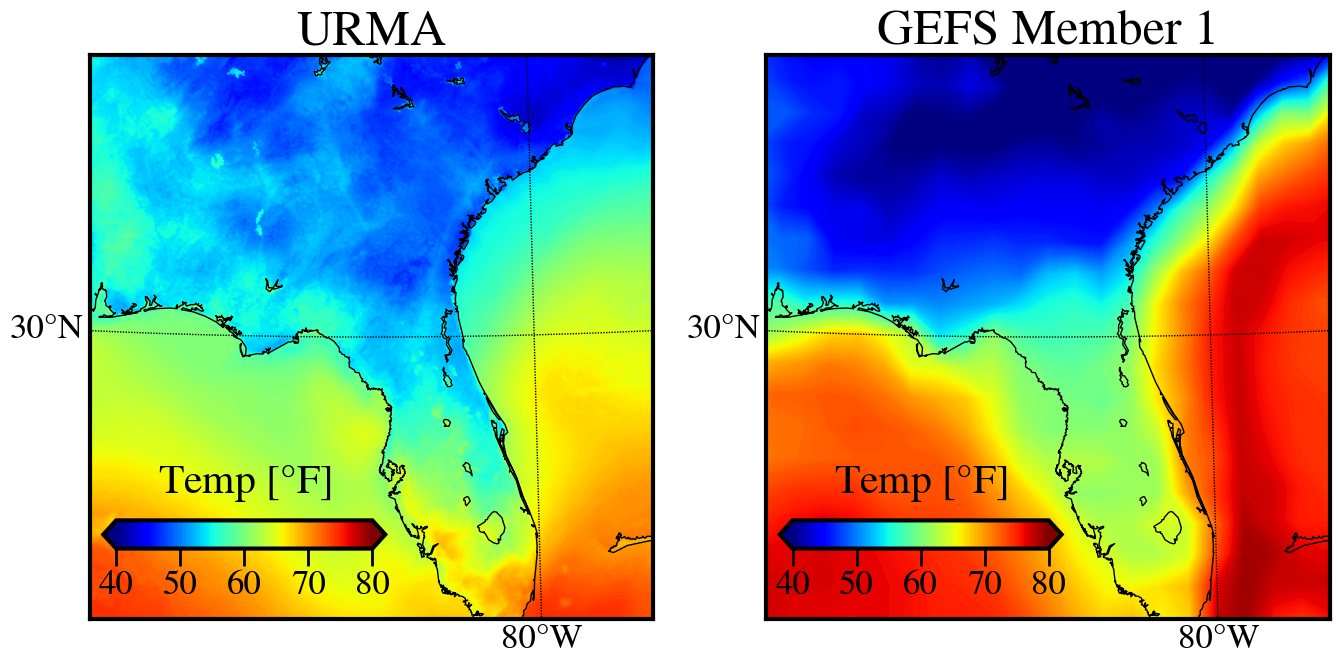

In [84]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

temp_range = np.linspace(40,80,200)

#original grid
lats, lons = u1.latitude.data, u1.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
u_tmp = u1.TMP.data * units(u1.TMP.units)
cs = m.contourf(xx,yy,u_tmp.to(units.fahrenheit),levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[0])
m.drawcoastlines(ax=axes[0])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[0])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[0])
#axes[0].contourf(lons, lats, temp_data.to(units.fahrenheit), cmap=cm.jet,levels=np.linspace(-10,100,100), extend='both')
cbar_ax = inset_axes(axes[0],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

#new grid
lats, lons = g1.latitude.data, g1.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
gefs_tmp = g1.TMP.data * units(g1.TMP.units)
cs = m.contourf(xx,yy,gefs_tmp.to(units.fahrenheit),levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[1])
m.drawcoastlines(ax=axes[1])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[1])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[1])
cbar_ax = inset_axes(axes[1],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[1].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

axes[0].set_title('URMA')
axes[1].set_title('GEFS Member 1')

So the GEFS members are on a (iirc) 1 degree grid, which is about 100 km. The URMA data is at much finer spatial resolution = 2.5 km! So let's interpolate GEFS onto the URMA grid.

In [85]:
#the xarray backend can make use of grib2io's interp functions to interpolate the data onto a different grid
grid_def_out = u1.grib2io.griddef()
gefs_to_urma = g1.TMP.grib2io.interp('bilinear', grid_def_out)

Text(0.5, 1.0, 'GEFS Member 1')

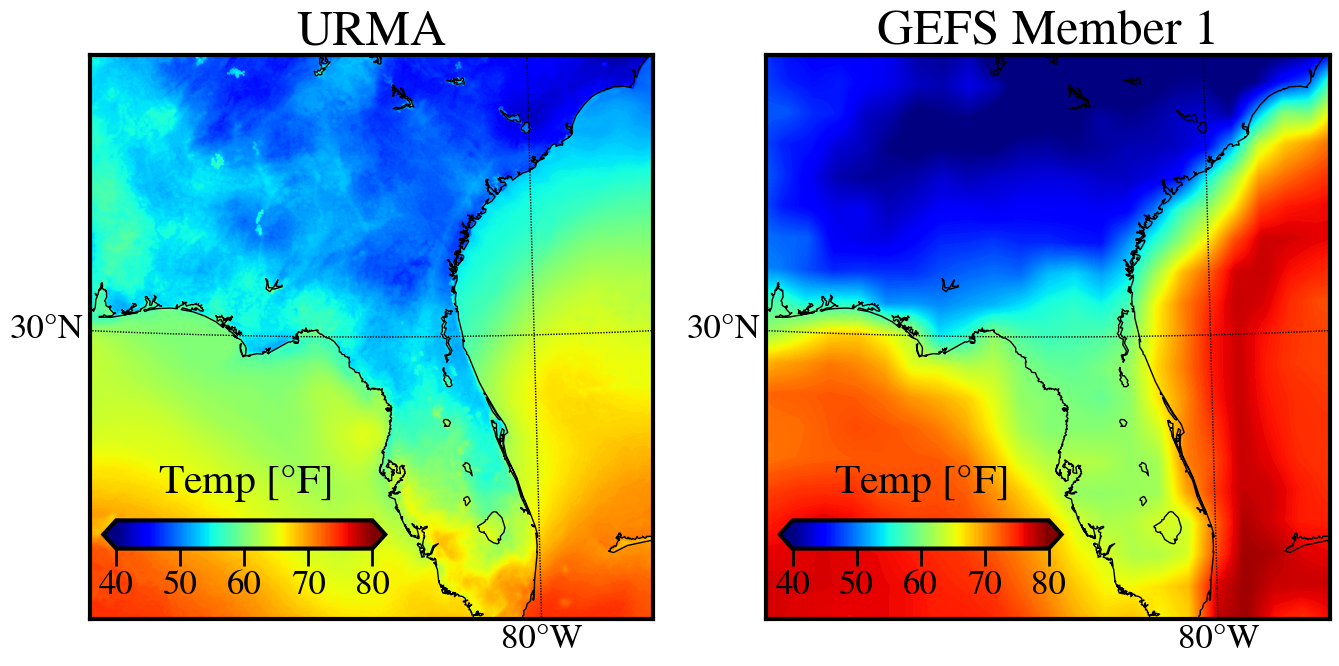

In [86]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

temp_range = np.linspace(40,80,200)

#original grid
lats, lons = u1.latitude.data, u1.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
u_tmp = u1.TMP.data * units(u1.TMP.units)
cs = m.contourf(xx,yy,u_tmp.to(units.fahrenheit),levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[0])
m.drawcoastlines(ax=axes[0])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[0])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[0])
#axes[0].contourf(lons, lats, temp_data.to(units.fahrenheit), cmap=cm.jet,levels=np.linspace(-10,100,100), extend='both')
cbar_ax = inset_axes(axes[0],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

#new grid
lats, lons = gefs_to_urma.latitude.data, gefs_to_urma.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
gefs_tmp = gefs_to_urma.data * units(g1.TMP.units)
cs = m.contourf(xx,yy,gefs_tmp.to(units.fahrenheit),levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[1])
m.drawcoastlines(ax=axes[1])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[1])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[1])
cbar_ax = inset_axes(axes[1],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[1].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

axes[0].set_title('URMA')
axes[1].set_title('GEFS Member 1')

In [89]:
#no discernable difference in the plotting but the shape of the GEFS data now matched the URMA grid 
np.shape(gefs_to_urma.data), np.shape(u1.TMP.data)

((1597, 2345), (1597, 2345))

Ok. Now we can turn to the QM exercise. 

In [2]:

#gather the previous 50 days of observation from  our 
urma_dir='/scratch2/STI/mdl-sti/Eric.Engle/urma_climo/urma/'
urma_paths = []
for days_ago in range(50):
    first_day=datetime.date(2020,1,29)   
    this_day = first_day - datetime.timedelta(days=days_ago)
    urma_paths.append(urma_dir+f'urma2p5.{this_day.strftime("%Y%m%d")}/urma2p5.t00z.2dvaranl_ndfd.grb2_wexp.grib2io')


filters = dict(productDefinitionTemplateNumber=0, typeOfFirstFixedSurface=103,shortName='TMP')
urma_data = xr.open_mfdataset(urma_paths, chunks=None,engine='grib2io', filters=filters, parallel=False, concat_dim=[
        pd.Index(np.arange(len(urma_paths)), name="obs_day"),
    ],
    combine="nested",)

What this xarray dataset represents is 50 days of URMA observations over the entire NBM CONUS grid. So each grid point has 50 historic temp values (at the same observation time each day) from which we can construct the CDF.

In [91]:
urma_data.TMP

<xarray.DataArray 'TMP' (obs_day: 50, y: 1597, x: 2345)>
dask.array<concatenate, shape=(50, 1597, 2345), dtype=float32, chunksize=(1, 1597, 2345), chunktype=numpy.ndarray>
Coordinates:
    refDate                   (obs_day) datetime64[ns] 2020-01-29 ... 2019-12-11
    leadTime                  timedelta64[ns] 00:00:00
    valueOfFirstFixedSurface  float64 2.0
    latitude                  (y, x) float64 dask.array<chunksize=(1597, 2345), meta=np.ndarray>
    longitude                 (y, x) float64 dask.array<chunksize=(1597, 2345), meta=np.ndarray>
    validDate                 (obs_day) datetime64[ns] 2020-01-29 ... 2019-12-11
  * obs_day                   (obs_day) int64 0 1 2 3 4 5 ... 44 45 46 47 48 49
Dimensions without coordinates: y, x
Attributes:
    GRIB2IO_section0:  [1196575042          0          0          2    3652869]
    GRIB2IO_section1:  [   7    4    1    1    0 2020    1   29    0    0    ...
    GRIB2IO_section3:  [        0   3744965         0         0        30    ...
    GRIB2IO_section4:  [  0   0   0   0   0   0 118   0   0   1   0 103   0  ...
    fullName:          Temperature
    shortName:         TMP
    units:             K

To downscale our problem, we will just focus on one grid point.

In [3]:
#get temperatures at tallahassee airport
urma_to_stat = urma_data.grib2io.interp_to_stations('bilinear', ['KTLH'], [30.4382], [-84.2806])
urma_tall_temp =(np.ravel(urma_to_stat.TMP.data.compute()) * units(urma_data.TMP.units)).to(units.fahrenheit)

Ok, now for the GEFS data. After lots of experimentation, I've found that loading in the GEFS grib2 files is a data volume headache -- loading in one file (with ~38,000 messages) takes about 8 seconds. We can handily pare this down by using files which include fewer pressure levels and lead times. We can also parallel-ize the loading with dask+xarray, though this process still takes ~2 minutes on 16 CPUs.


In [4]:
#get GEFS members
import dask
dask.config.set(scheduler='processes', num_workers=16)

adam_dat_dir = '/scratch1/NCEPDEV/mdl/Adam.Schnapp/noscrub/data/gefs/20230129/atmos/pgrb2ap5/'
gefs_paths = sorted(glob(adam_dat_dir+'gep*.t12z.pgrb2a.0p50.f000'))
filters = dict(productDefinitionTemplateNumber=1, typeOfFirstFixedSurface=103,valueOfFirstFixedSurface=2.0)
now = datetime.datetime.now()
gefs_data = xr.open_mfdataset(gefs_paths, chunks=None,engine='grib2io', filters=filters, parallel=True, concat_dim=[pd.Index(np.arange(len(gefs_paths)), name="member")],combine="nested")
done = datetime.datetime.now()
print(done - now)

0:01:28.063329


This dataset represents the gridded data from 30 ensemble members that make up GEFS. In reality, the grib2 files for each ensemble member would contain messages at all lead times and atmospheric levels, but here we just included 1 level and 1 lead time.

In [12]:
gefs_data.TMP

<xarray.DataArray 'TMP' (member: 30, y: 361, x: 720)>
dask.array<concatenate, shape=(30, 361, 720), dtype=float32, chunksize=(1, 361, 720), chunktype=numpy.ndarray>
Coordinates:
    refDate                   datetime64[ns] 2023-01-29T12:00:00
    leadTime                  timedelta64[ns] 00:00:00
    valueOfFirstFixedSurface  float64 2.0
    perturbationNumber        (member) int64 1 2 3 4 5 6 7 ... 25 26 27 28 29 30
    latitude                  (y, x) float64 dask.array<chunksize=(361, 720), meta=np.ndarray>
    longitude                 (y, x) float64 dask.array<chunksize=(361, 720), meta=np.ndarray>
    validDate                 datetime64[ns] 2023-01-29T12:00:00
  * member                    (member) int64 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
Dimensions without coordinates: y, x
Attributes:
    GRIB2IO_section0:  [1196575042          0          0          2     246717]
    GRIB2IO_section1:  [   7    2    2    1    1 2023    1   29   12    0    ...
    GRIB2IO_section3:  [        0    259920         0         0         0    ...
    GRIB2IO_section4:  [  0   1   0   0   4   0 107   0   0   1   0 103   0  ...
    fullName:          Temperature
    shortName:         TMP
    units:             K

In [5]:
#get temperature forecasts at tallahassee airport
gefs_to_stat = gefs_data.grib2io.interp_to_stations('bilinear', ['KTLH'], [30.4382], [-84.2806])
gefs_tall_temp = (np.ravel(gefs_to_stat.TMP.data.compute()) * units(gefs_data.TMP.units)).to(units.fahrenheit)

Text(0.5, 0, 'KTLH Temperature [$\\degree$F]')

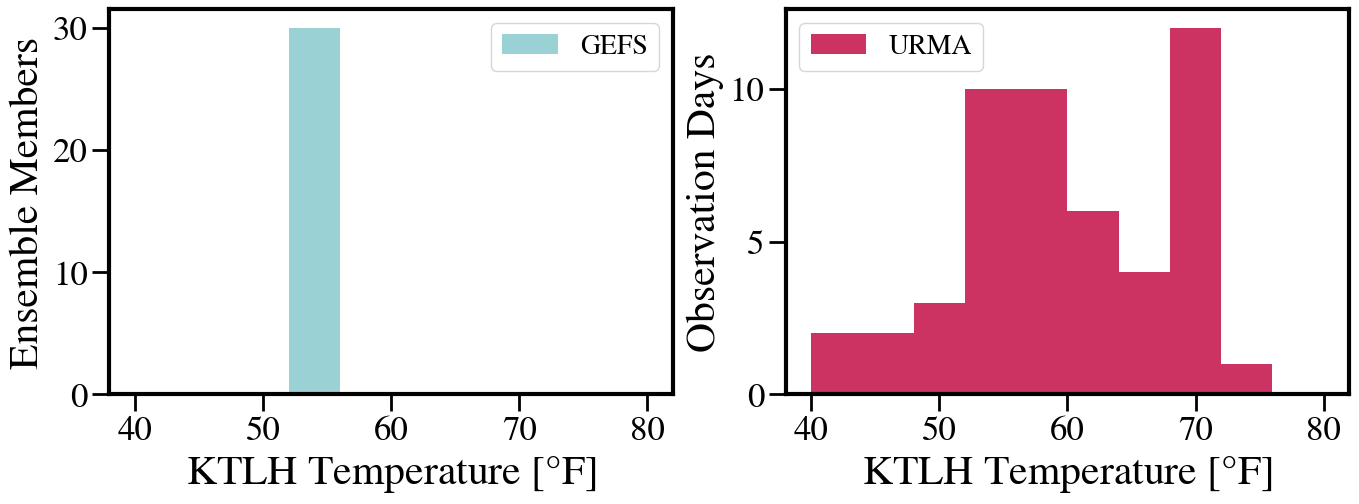

In [84]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(16,5))
bins=10
hrange=(40,80)
axes[0].hist(gefs_tall_temp, bins=bins, range=range,color='#9AD1D4',label='GEFS')
axes[1].hist(urma_tall_temp, bins=bins, range=range,color='#CC3363',label='URMA')
axes[0].set_xlabel('KTLH Temperature [$\degree$F]')
axes[0].set_ylabel('Ensemble Members')
axes[1].set_ylabel('Observation Days')
axes[0].legend()
axes[1].legend()
axes[1].set_xlabel('KTLH Temperature [$\degree$F]')

(Again not super correct since the GEFS and URMA data are from two different time periods BUT) We can see there is much more spread in the actual temperatures over the past 50 days compared to the GEFS model prediction.

In [13]:
urma_cdf=ECDF(urma_tall_temp)

In [14]:
gefs_cdf = ECDF(gefs_tall_temp)

Text(0.5, 1.0, 'KTLH 2023-01-29T12:00:00.000000000')

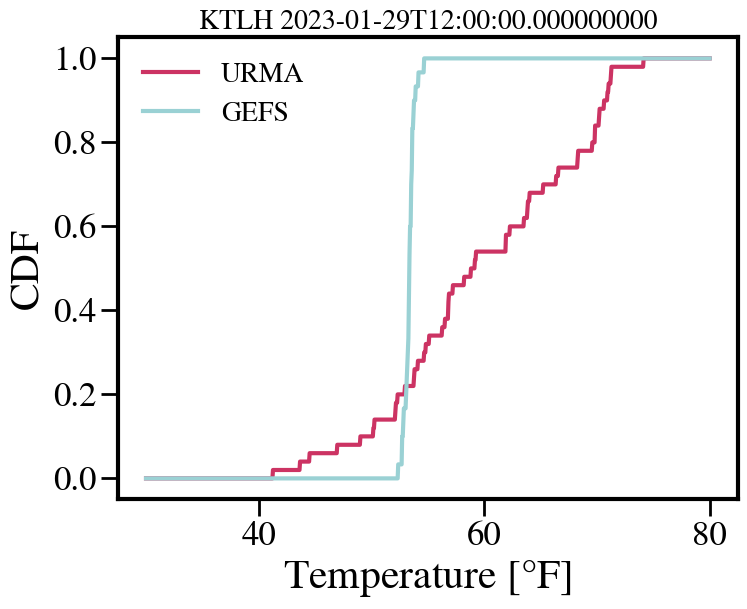

In [42]:
x=np.linspace(30,80,1000)

plt.plot(x, urma_cdf(x), color='#CC3363', lw=3,label='URMA')
plt.plot(x, gefs_cdf(x), color='#9AD1D4', lw=3,label='GEFS')
plt.xlabel('Temperature [$\degree$F]')
plt.ylabel('CDF')
plt.legend(frameon=False)
plt.title(f'KTLH {gefs_data.refDate.data}', fontsize=20)

As stated before, the GEFS data and URMA are not from the same time period. But at least for demonstration purposes we can now do the QM calculations.

Though we can construct the CDFS empirically from each dataset, in the blend this is swapped for fitting the data to a theoretical Gaussian distribution - this gets rid of the necessicity to carry around the CDF quantiles and allows us to describe each dataset with only 2 params (loc and scale) for temp (or a 4 param Gamma dist for precipitation since there's an extra variable to control for the number of days without precipitation.)

In [6]:
gefs_distribution = scipy.stats.norm(*scipy.stats.norm.fit(gefs_tall_temp))

urma_distribution = scipy.stats.norm(*scipy.stats.norm.fit(urma_tall_temp))

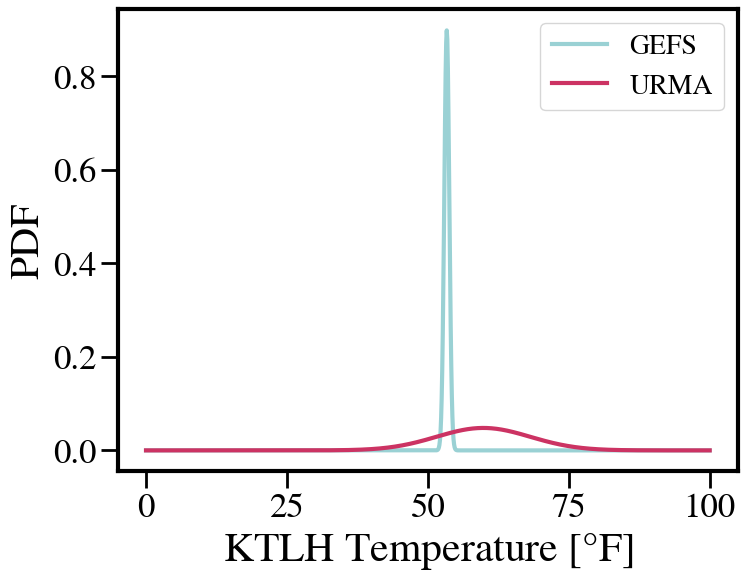

In [7]:
draws = np.linspace(0,100,1000)
plt.plot(draws, gefs_distribution.pdf(draws),color='#9AD1D4', lw=3,label='GEFS')
plt.plot(draws, urma_distribution.pdf(draws),color='#CC3363', lw=3,label='URMA')
plt.ylabel('PDF')
plt.xlabel('KTLH Temperature [$\degree$F]')
plt.legend()

In [8]:
corrected_gefs = urma_distribution.ppf(gefs_distribution.cdf(gefs_tall_temp)) #again from Eq 1 of Cannon+15

Text(0.5, 0, 'KTLH Temperature [$\\degree$F]')

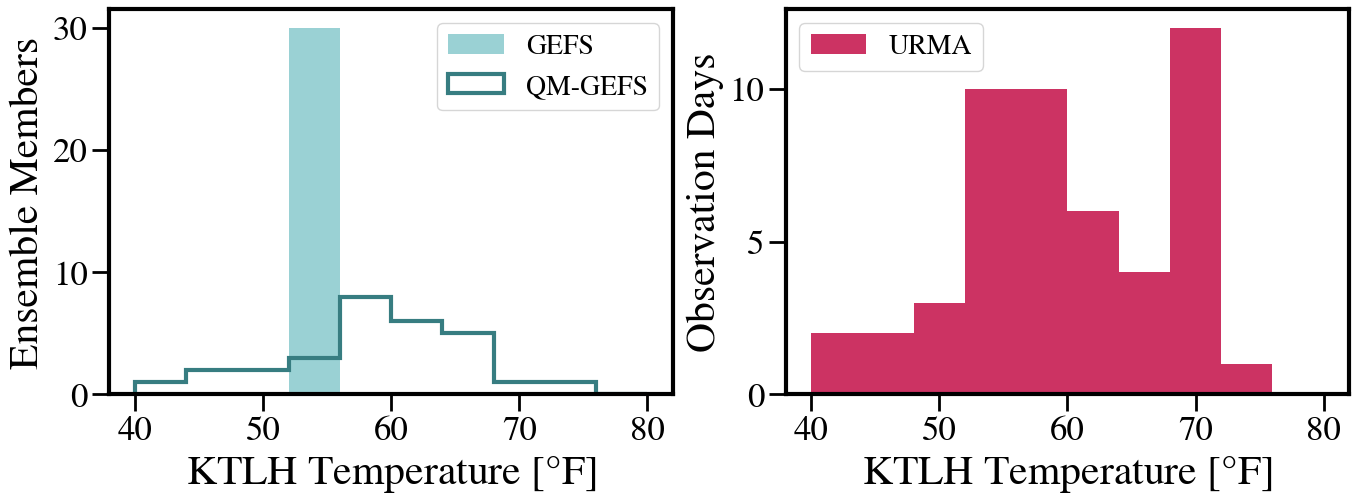

In [10]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(16,5))
#plt.subplots_adjust(wspace=0.4)
bins=10

hrange=(40,80)
axes[0].hist(gefs_tall_temp, bins=bins, range=hrange,color='#9AD1D4',label='GEFS')
axes[0].hist(corrected_gefs, bins=bins, range=hrange,color='#377D81',lw=3,histtype='step', label='QM-GEFS')
axes[1].hist(urma_tall_temp, bins=bins, range=hrange,color='#CC3363',label='URMA')
axes[0].set_xlabel('KTLH Temperature [$\degree$F]')
axes[0].set_ylabel('Ensemble Members')
axes[1].set_ylabel('Observation Days')
axes[0].legend()
axes[1].legend()
axes[1].set_xlabel('KTLH Temperature [$\degree$F]')

Text(0.5, 1.0, 'KTLH 2023-01-29T12:00:00.000000000')

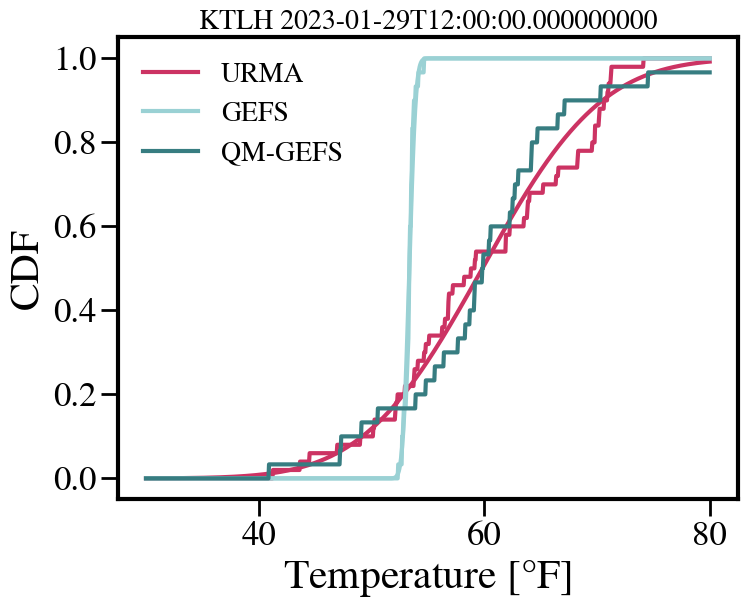

In [16]:
x=np.linspace(30,80,1000)

plt.plot(x, urma_distribution.cdf(x), color='#CC3363', lw=3,label='URMA')
plt.plot(x, urma_cdf(x), color='#CC3363', lw=3,)
plt.plot(x, gefs_distribution.cdf(x), color='#9AD1D4', lw=3,label='GEFS')
plt.plot(x, gefs_cdf(x), color='#9AD1D4', lw=3,)
plt.plot(x, ECDF(corrected_gefs)(x),color='#377D81',lw=3,label='QM-GEFS' )
plt.xlabel('Temperature [$\degree$F]')
plt.ylabel('CDF')
plt.legend(frameon=False)
plt.title(f'KTLH {gefs_data.refDate.data}', fontsize=20)

## Exercise with Real Data: Quantile Mapping Gridded Data 2.0

I think I'd have to interp the GEFS data to the URMA grid (like above) and then...loop through each grid point to get the CDF? to QM map at each location instead of making a CDF of all grid points? Right? Which sounds....daunting. OK. Let's reframe. 

Instead of gridding to URMA resolution, let's upscale URMA to GEFS. just to reduce the data volume.

In [17]:
gefs_grid = gefs_data.grib2io.griddef()
urma_to_gefs = urma_data.grib2io.interp('bilinear', gefs_grid)
#urma_temps_up = np.ravel(urma_to_gefs.data.compute()) * units(gefs_data.TMP.units)

In [257]:
urma_to_gefs

<xarray.Dataset>
Dimensions:                   (obs_day: 50, y: 361, x: 720)
Coordinates:
    refDate                   (obs_day) datetime64[ns] 2020-01-29 ... 2019-12-11
    leadTime                  timedelta64[ns] 00:00:00
    valueOfFirstFixedSurface  float64 2.0
    validDate                 (obs_day) datetime64[ns] 2020-01-29 ... 2019-12-11
  * obs_day                   (obs_day) int64 0 1 2 3 4 5 ... 44 45 46 47 48 49
    longitude                 (y, x) float64 0.0 0.5 1.0 ... 358.5 359.0 359.5
    latitude                  (y, x) float64 90.0 90.0 90.0 ... -90.0 -90.0
Dimensions without coordinates: y, x
Data variables:
    TMP                       (obs_day, y, x) float32 dask.array<chunksize=(1, 361, 720), meta=np.ndarray>
Attributes:
    engine:            grib2io
    GRIB2IO_section3:  [        0    259920         0         0         0    ...

In [62]:
# Fit the parameters along the time dimension
#after a long search, a solution! https://stackoverflow.com/questions/51565708/using-scipy-stats-to-fit-xarray-dataarray
urma_fit = dask.array.apply_along_axis(scipy.stats.norm.fit, urma_to_gefs.TMP.get_axis_num('obs_day'),
                                   ((urma_to_gefs.TMP.data)*units.kelvin).to(units.fahrenheit).magnitude)


#not directly applicable but still useful to know: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.curvefit.html

In [57]:
urma_params=urma_fit.compute()

In [58]:
np.shape(urma_params) #[2=loc,scale; lat; lon]

(2, 361, 720)

In [59]:
# Fit the parameters along the member dimension
gefs_fit = dask.array.apply_along_axis(scipy.stats.norm.fit, gefs_data.TMP.get_axis_num('member'),
                                   ((gefs_data.TMP.data)*units.kelvin).to(units.fahrenheit).magnitude)

In [60]:
gefs_params=gefs_fit.compute()

Text(0.5, 1.0, 'GEFS 30 member mean')

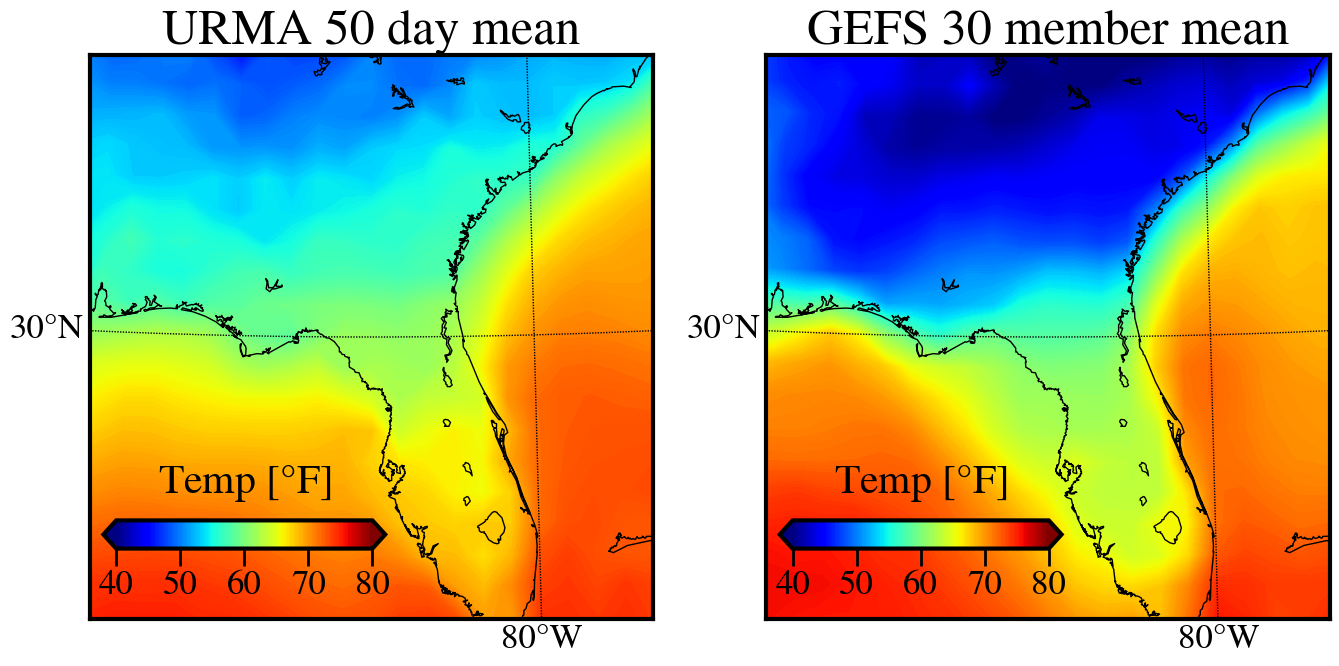

In [61]:
#plot urma and gefs temp means
fig, axes = plt.subplots(1,2, figsize=(16,8))
temp_range = np.linspace(40,80,200)

lats, lons = urma_to_gefs.latitude.data, urma_to_gefs.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
urma_mean = urma_params[0,:,:]
cs = m.contourf(xx,yy,urma_mean,levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[0])
m.drawcoastlines(ax=axes[0])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[0])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[0])
#axes[0].contourf(lons, lats, temp_data.to(units.fahrenheit), cmap=cm.jet,levels=np.linspace(-10,100,100), extend='both')
cbar_ax = inset_axes(axes[0],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

#new grid
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
gefs_mean = gefs_params[0,:,:]
cs = m.contourf(xx,yy,gefs_mean,levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[1])
m.drawcoastlines(ax=axes[1])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[1])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[1])
cbar_ax = inset_axes(axes[1],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[1].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

axes[0].set_title('URMA 50 day mean')
axes[1].set_title('GEFS 30 member mean')

So now we've fit a Gaussian distribution to the 50-day URMA observations for every grid point (downscaled to GEFS resolution just to reduce data volume) and the 30 member GEFS data. We can now use those fit parameters to construct a Gaussian CDF for every point in both datasets and then map the quantiles

In [65]:
gefs_temps = ((gefs_data.TMP.data.compute())*units.kelvin).to(units.fahrenheit).magnitude

In [194]:
np.shape(gefs_temps)

(30, 361, 720)

Which...is easier said than done? I'm _sure_ there is a way to dask/xarray this like above. but the issue is getting the urma ds to talk with the gefs ds at each grid point. so a hack with multiprocessing it is.

In [69]:
from tqdm.auto import tqdm

In [79]:
from multiprocessing import Pool

In [152]:
#just....the worst way to do this probably
def get_qm(lat_idx):
    this_latlon = np.empty((30,720)) #for 30 members
    for i in range(720):
        urma_dist_at_latlon = scipy.stats.norm(*urma_params[:,lat_idx, i])
        gefs_dist_at_latlon = scipy.stats.norm(*gefs_params[:,lat_idx, i])
        this_latlon[:,i]=urma_dist_at_latlon.ppf(gefs_dist_at_latlon.cdf(gefs_temps[:,lat_idx,i]))
    return this_latlon

In [153]:
with Pool(16) as p:
    out1 = list(tqdm(p.imap(get_qm, np.arange(361)), total=361))
    

  0%|          | 0/361 [00:00<?, ?it/s]

In [95]:
np.shape(out1)

(361, 30, 720)

Text(0.5, 1.0, 'GEFS-QM 30 member mean')

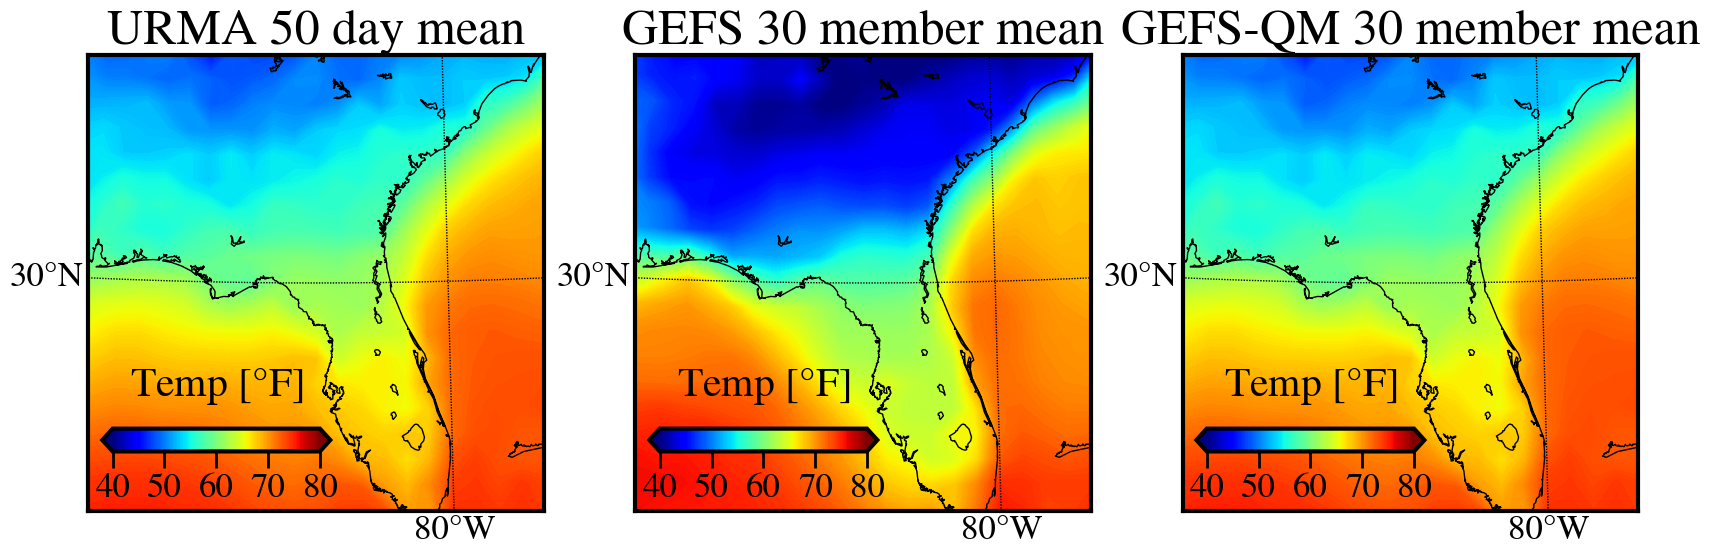

In [99]:
#plot urma and gefs temp means
fig, axes = plt.subplots(1,3, figsize=(20,8))
temp_range = np.linspace(40,80,200)

lats, lons = urma_to_gefs.latitude.data, urma_to_gefs.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
urma_mean = urma_params[0,:,:]
cs = m.contourf(xx,yy,urma_mean,levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[0])
m.drawcoastlines(ax=axes[0])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[0])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[0])
#axes[0].contourf(lons, lats, temp_data.to(units.fahrenheit), cmap=cm.jet,levels=np.linspace(-10,100,100), extend='both')
cbar_ax = inset_axes(axes[0],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[0].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

#uncorrected GEFS
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
gefs_mean = gefs_params[0,:,:]
cs = m.contourf(xx,yy,gefs_mean,levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[1])
m.drawcoastlines(ax=axes[1])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[1])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[1])
cbar_ax = inset_axes(axes[1],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[1].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

#QM corrected gefs
lats, lons = gefs_data.latitude.data, gefs_data.longitude.data
m = Basemap(projection='lcc',lon_0=-83,lat_0=30,width=1e6,height=1e6,resolution='i')
xx, yy = m(lons, lats) #note to self, x=lons y=lats
gefs_mean = np.mean(out1, axis=1)
cs = m.contourf(xx,yy,gefs_mean,levels=temp_range,cmap=plt.cm.jet,extend='both',ax=axes[2])
m.drawcoastlines(ax=axes[2])
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=25,ax=axes[2])
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=25,ax=axes[2])
cbar_ax = inset_axes(axes[2],
                    width="50%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower left',bbox_to_anchor=(0, 0.1, 1, 1),bbox_transform=axes[2].transAxes)

cbar=plt.colorbar(cs, cax=cbar_ax, orientation="horizontal",ticks=np.arange(np.min(temp_range),np.max(temp_range)+10,10))
cbar.set_label('Temp [$\degree$F]',labelpad=-100)

axes[0].set_title('URMA 50 day mean')
axes[1].set_title('GEFS 30 member mean')
axes[2].set_title('GEFS-QM 30 member mean')

Let's take a look at the CDFs for a single grid point, just to verify they make sense.

In [200]:
lat, lon = 100,550 #roughly tallahassee lat and lon
corrected_values = np.asarray(out1)[lat, :,lon]
urma_dist_at_latlon = scipy.stats.norm(*urma_params[:,lat,lon])
gefs_dist_at_latlon = scipy.stats.norm(*gefs_params[:,lat,lon])

Text(0.5, 1.0, 'lat=40.0$\\degree$N, lon=85.0$\\degree$W\n2023-01-29T12:00:00.000000000')

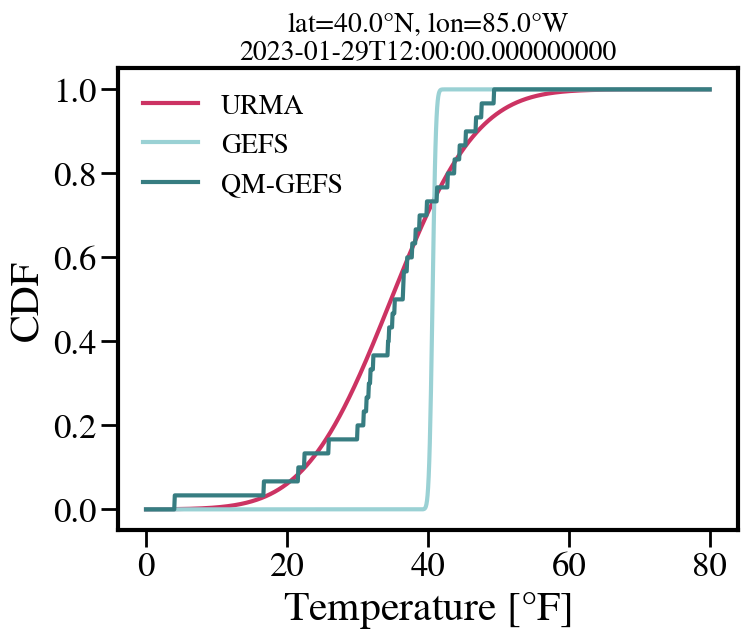

In [201]:
x=np.linspace(0,80,1000)

plt.plot(x, urma_dist_at_latlon.cdf(x), color='#CC3363', lw=3,label='URMA')
plt.plot(x, gefs_dist_at_latlon.cdf(x), color='#9AD1D4', lw=3,label='GEFS')
plt.plot(x, ECDF(corrected_values)(x),color='#377D81',lw=3,label='QM-GEFS' )
plt.xlabel('Temperature [$\degree$F]')
plt.ylabel('CDF')
plt.legend(frameon=False)
plt.title(f'lat={g1.latitude.data[lat,0]:.1f}$\degree$N, lon={-1*((g1.longitude.data[0,lon] + 180) % 360 - 180):.1f}$\degree$W\n{gefs_data.refDate.data}', fontsize=20)

Nice !

## Coalescence

In the blend, there are ~17 models used to construct the value distributions for each variable (temp, precip, etc.). Some of these models are themselves made of an ensemble of models with different perturbation states (so in reality, 200+ realizations). In QM, each of these ensemble members would be mapped to the CDF constructed from the entire sample, but this can introduce issues originating from errors in the magnitude, timing, and location of weather events. Coalecence attempts to conform these ensemble members to the ensemble mean using the feature align technique in order to alleviate these errors while maintaining the distribution of events predicted by the individual ensemble members. 